In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
FOLDER_PATH = "Images/100"
IMG_SIZE = 224
CNN_MODEL_PATH = "CNN_model.pth"

In [ ]:
labels = ["Immune_Cells", "Non_Invasive_Tumor", "Invasive_Tumor_Set"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)

['Immune_Cells' 'Non_Invasive_Tumor' 'Invasive_Tumor_Set']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(labels))  
model.load_state_dict(torch.load(CNN_MODEL_PATH))
model.eval()

cam_extractor = GradCAM(model, target_layer="layer4") # the last conv layer

transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

c:\Users\brian\Desktop\DATA3888\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\brian\Desktop\DATA3888\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Get the heatmap

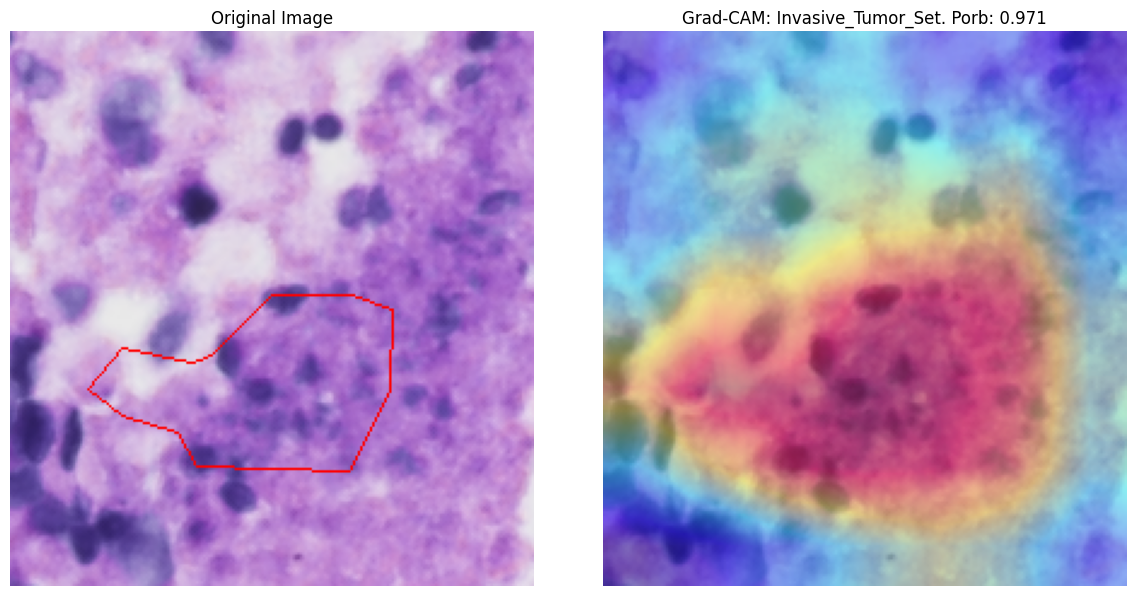

In [ ]:
img_path = "example.png"
pil_img = Image.open(img_path).convert('RGB')
input_tensor = transform(pil_img).unsqueeze(0)  # Add batch dimension

output = model(input_tensor)
probs = F.softmax(output, dim=1)
pred_class = output.argmax().item()
prob = probs[0, pred_class].item()

activation_map = cam_extractor(pred_class, output)

heatmap = activation_map[0].squeeze().cpu().numpy()
heatmap_resized = cv2.resize(heatmap, pil_img.size)
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

# Threshold + contour
_, thresh = cv2.threshold(heatmap_uint8, 220, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding box
img_cv = np.array(pil_img)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(img_cv, 0.6, heatmap_color, 0.4, 0)

for cnt in contours:
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    cv2.drawContours(img_cv, [approx], -1, (0, 0, 255), 1)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM: {le.inverse_transform([pred_class])[0]}. Porb: {prob:.3f}")
plt.axis("off")

plt.tight_layout()
plt.show()